In [549]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [550]:
train_df = pd.read_csv('./data/regression_train.csv')
test_df = pd.read_csv('./data/regression_test.csv')
concat_df = pd.concat([train_df, test_df])

### Preprocessing

In [551]:
concat_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8125   Pave   NaN      Reg   
1          80       RL         75.0     9750   Pave   NaN      Reg   
2         160       FV          NaN     5105   Pave   NaN      IR2   
3          20       RL         50.0     9405   Pave   NaN      Reg   
4          50       RL         78.0    10496   Pave   NaN      Reg   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub    Inside  ...        0    NaN  GdWo         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      3    2009        WD         Normal     174000  
1       0     10    2006        WD         Normal     135500  
2       0      3    2007        WD         Normal     148800  
3       0      6    2009        WD         Normal     118000  
4       0      1    2007        WD         Normal     143000  

[5 rows x 80 columns]

heatmap

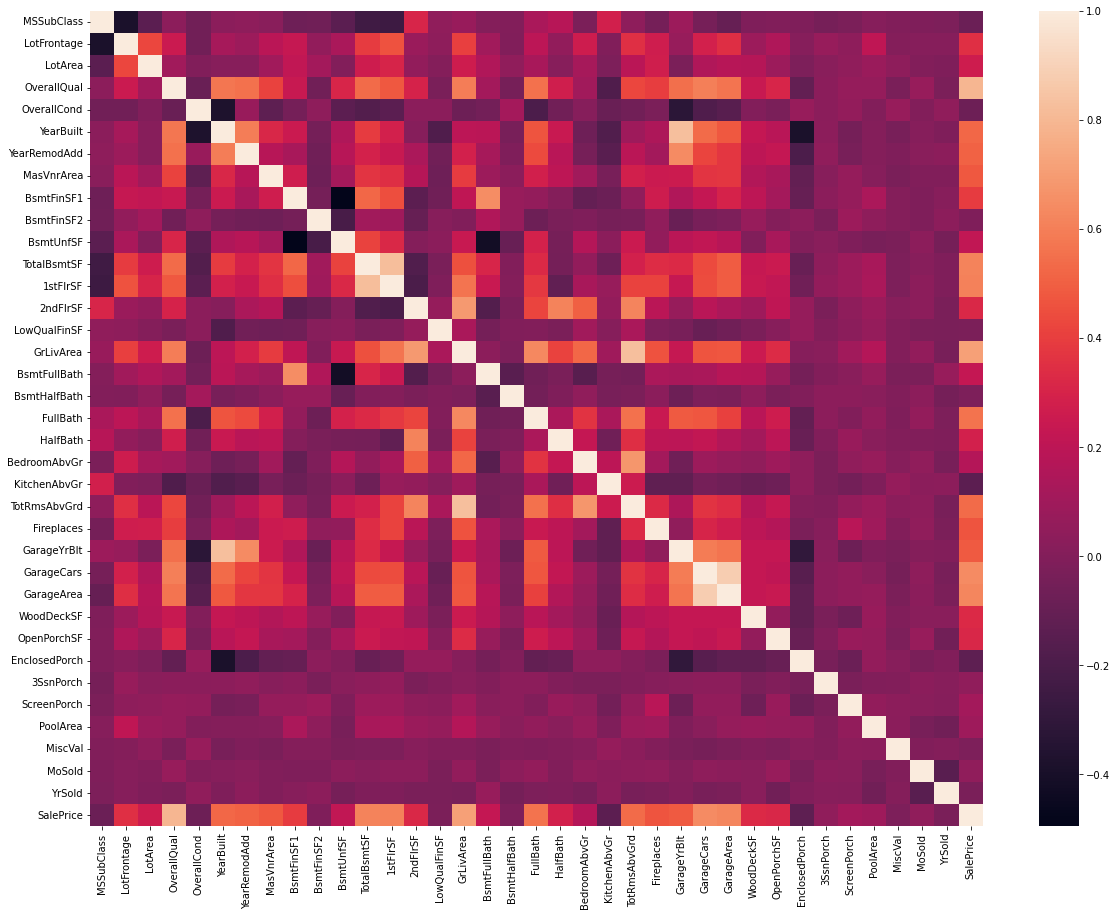

In [552]:
plt.figure(figsize=(20*1,15*1))
sns.heatmap(concat_df.corr())
plt.show()

In [553]:
corr_matrix = concat_df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
tuples_with_saleprice = [tup for tup in sol.keys() if 'SalePrice' in tup]

sol[tuples_with_saleprice]

# Remove features???? Why remove one????? Why find them with highest correlations and remove them???? why??????

OverallQual    SalePrice    0.790913
GrLivArea      SalePrice    0.708478
GarageCars     SalePrice    0.640189
GarageArea     SalePrice    0.623305
TotalBsmtSF    SalePrice    0.613784
1stFlrSF       SalePrice    0.606246
FullBath       SalePrice    0.560458
TotRmsAbvGrd   SalePrice    0.533377
YearBuilt      SalePrice    0.522590
YearRemodAdd   SalePrice    0.506816
GarageYrBlt    SalePrice    0.486046
MasVnrArea     SalePrice    0.478019
Fireplaces     SalePrice    0.466750
BsmtFinSF1     SalePrice    0.387226
LotFrontage    SalePrice    0.351529
WoodDeckSF     SalePrice    0.324238
2ndFlrSF       SalePrice    0.318814
OpenPorchSF    SalePrice    0.315125
HalfBath       SalePrice    0.283596
LotArea        SalePrice    0.263905
BsmtFullBath   SalePrice    0.227723
BsmtUnfSF      SalePrice    0.213995
BedroomAbvGr   SalePrice    0.168161
KitchenAbvGr   SalePrice    0.135819
EnclosedPorch  SalePrice    0.128403
ScreenPorch    SalePrice    0.111639
PoolArea       SalePrice    0.092469
M

### Handle null values

In [554]:
total_null_values = concat_df.isna().sum().sum()

print(f'Total null values: {total_null_values}')

Total null values: 6961


#### 1. Threshold for columns (if null values is over 50 % of column)

In [555]:
series = concat_df.isnull().sum()
series_filtered = series[series > 0]

total_rows = concat_df.shape[0]
threshold = 0.5
series_filtered_mask = (series_filtered / total_rows) > threshold

columns_to_remove = list(series_filtered[series_filtered_mask].keys())

concat_df.drop(columns_to_remove, inplace=True, axis=1)

print(f'Removed columns that has over 50 % null values : {columns_to_remove}')

Removed columns that has over 50 % null values : ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [556]:
total_null_values = concat_df.isna().sum().sum()

print(f'Total null values: {total_null_values}')

Total null values: 1558


#### 2. Threshold for rows (if row has over 10 missing values)

In [557]:
null_mask =  ~(concat_df.isnull().sum(axis=1) > 10)
filtered_df = concat_df[null_mask]

print(f'removed {concat_df.shape[0] - filtered_df.shape[0]} rows')

removed 6 rows


In [558]:
total_null_values = filtered_df.isna().sum().sum()

print(f'Total null values: {total_null_values}')

Total null values: 1492


#### 3. Fill empty strings with syntethic data through most frequent class

In [559]:
filtered_df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [560]:
mask = filtered_df.dtypes == 'O'
columns_to_string = filtered_df.select_dtypes('O')

for column in columns_to_string:
    most_frequent = filtered_df[column].value_counts().keys()[0]
    filtered_df[column] = filtered_df[column].fillna(most_frequent).copy()

In [561]:
total_null_values = filtered_df.isna().sum().sum()

print(f'Total null values: {total_null_values}')

Total null values: 342


#### 4. Fill empty floats with syntetic data through mean of the class

##### We could also remove classes, but we wanted to try to keep so much data as possible. We will try inference without these classes for comparison. 

In [562]:
mask = filtered_df.isnull().sum() > 0
columns = filtered_df.columns[mask]
columns_to_fix = filtered_df[columns]

for column in columns_to_fix:
    mean = columns_to_fix[column].mean()
    filtered_df[column] = columns_to_fix[column].replace(np.NAN, mean)
    
print(f'Doing syntetic data on : {list(columns)}')

Doing syntetic data on : ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [563]:
total_null_values = filtered_df.isna().sum().sum()

print(f'Total null values: {total_null_values}')

Total null values: 0


#### Analyse data through correlations

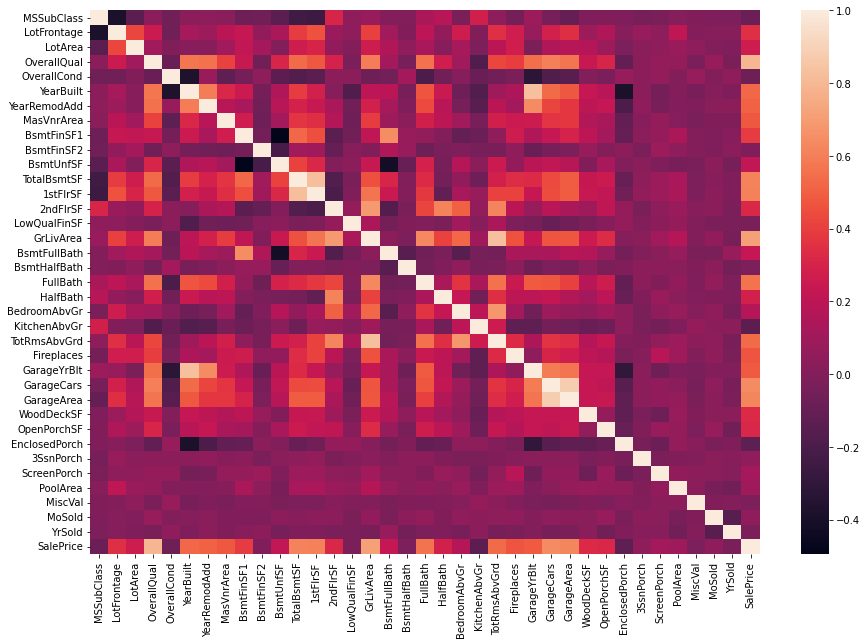

In [564]:
plt.figure(figsize=(15,10))
sns.heatmap(concat_df.corr())
plt.show()

### Removing the feature with highest correlation

In [565]:
correlations = concat_df.corr().abs()
correlations = correlations[correlations != 1]
correlations.unstack().sort_values(ascending=False)[:10]

GarageCars    GarageArea      0.882268
GarageArea    GarageCars      0.882268
GarageYrBlt   YearBuilt       0.825519
YearBuilt     GarageYrBlt     0.825519
TotRmsAbvGrd  GrLivArea       0.825468
GrLivArea     TotRmsAbvGrd    0.825468
TotalBsmtSF   1stFlrSF        0.819549
1stFlrSF      TotalBsmtSF     0.819549
OverallQual   SalePrice       0.790913
SalePrice     OverallQual     0.790913
dtype: float64

In [566]:
filtered_df.drop('GarageCars', axis=1, inplace=True)

### One-hot encoding

In [567]:
mask = filtered_df.dtypes == 'O'
string_datatype_df = filtered_df.select_dtypes('O')

for col_name in string_datatype_df:
    one_hot_df = pd.get_dummies(string_datatype_df[col_name])
    filtered_df = pd.concat([filtered_df, one_hot_df], axis=1).drop(col_name, axis=1)

In [568]:
filtered_df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [569]:
print("Example of one-hot encoding: ")

one_hot_df.head()

Example of one-hot encoding: 


Abnorml  AdjLand  Alloca  Family  Normal  Partial
0        0        0       0       0       1        0
1        0        0       0       0       1        0
2        0        0       0       0       1        0
3        0        0       0       0       1        0
4        0        0       0       0       1        0

### Finished preprocessing

In [570]:
filtered_df.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60    65.000000     8125            6            5       1994   
1          80    75.000000     9750            5            5       1967   
2         160    70.077889     5105            7            5       2004   
3          20    50.000000     9405            5            9       1947   
4          50    78.000000    10496            6            6       1949   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  ConLw  New  Oth  WD  \
0          1995         0.0           0           0  ...      0    0    0   1   
1          1967         0.0         400         480  ...      0    0    0   1   
2          2004         0.0         239           0  ...      0    0    0   1   
3          2008         0.0           0           0  ...      0    0    0   1   
4          1950       320.0         196           0  ...      0    0    0   1   

   Abnorml  AdjLand  Alloca  Family  Normal  Partial  
0        0        0       0       0       1        0  
1        0        0       0       0       1        0  
2        0        0       0       0       1        0  
3        0        0       0       0       1        0  
4        0        0       0       0       1        0  

[5 rows x 274 columns]

### Saving preprocessed df for VG assignment

In [571]:
filtered_df.to_csv('./data/regression_cleaned.csv', index=False)

### Using Random forest model for regression

In [572]:
y = filtered_df['SalePrice']
X = filtered_df.drop('SalePrice', axis=1)

#### Splitting data into train and test data

In [573]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [574]:
X_train.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
64           50    79.000000     9492            5            5       1941   
145          60    85.000000    10574            8            5       2005   
794          60    70.000000     8400            8            6       2001   
725          20    80.000000     9920            5            5       1954   
374         120    70.077889     4500            6            5       1999   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  ConLw  New  Oth  \
64           1950         0.0         368          41  ...      0    0    0   
145          2006         0.0           0           0  ...      0    0    0   
794          2001         0.0         643           0  ...      0    0    0   
725          1954       110.0         354         290  ...      0    0    0   
374          1999       425.0         883           0  ...      0    0    0   

     WD  Abnorml  AdjLand  Alloca  Family  Normal  Partial  
64    1        0        0       0       0       1        0  
145   1        0        0       0       0       1        0  
794   1        0        0       0       0       1        0  
725   1        0        0       0       0       1        0  
374   1        0        0       0       0       1        0  

[5 rows x 273 columns]

#### Training model


##### Note that we do not test different hyperparameters at g stage

In [575]:
forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion="mse")
forest.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=10, n_estimators=20)

### Inference

In [576]:
prediction = forest.predict(X_test)
score = mean_squared_error(y_test, prediction)
deviations = abs(y_test - prediction)

print(f'Total mse: {score}\n')
print("Results through difference between mse of individual inferences:\n")
print(f'Worst result: {np.max(deviations)}')
print(f'Best result: {np.min(deviations)}')
print(f'Mean deviation: {np.mean(deviations)}')

Total mse: 926049158.6512067

Results through difference between mse of individual inferences:

Worst result: 170813.16428571427
Best result: 5.689962094067596
Mean deviation: 17883.562122228697


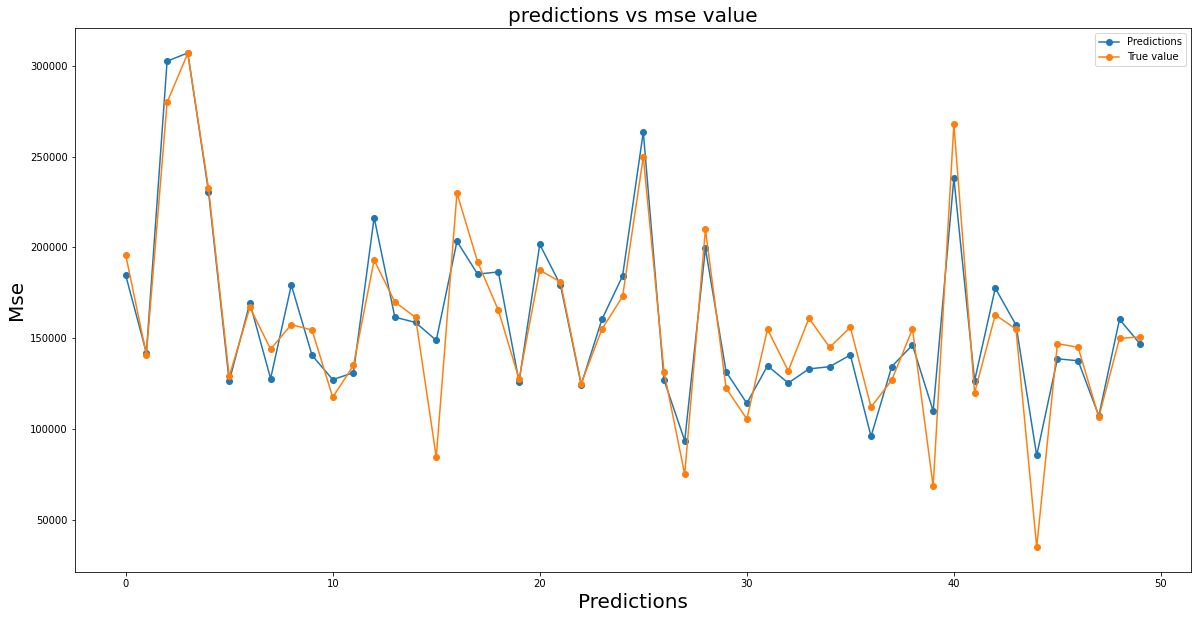

Through 50 examples used for this graph, we can see that predictions often follows true value closely.


In [577]:
figure = plt.figure(figsize=(20, 10))
length = len(prediction[:50])
plt.title('predictions vs mse value', fontsize=20)
plt.plot(range(length), prediction[:50], marker='o')
plt.plot(range(length), y_test[:50], marker='o')
plt.xlabel("Predictions", fontsize=20)
plt.ylabel('Mse', fontsize=20)
plt.legend(['Predictions', 'True value'])
plt.show()

print("Through 50 examples used for this graph, we can see that predictions often follows true value closely.")

#### Small experiment inference without  ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'] as we used syntetic data on them

In [578]:
X_experiment = X.drop(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], axis=1)

forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion="mse")
forest.fit(X_train, y_train)

prediction = forest.predict(X_test)
score_experiment = mean_squared_error(y_test, prediction)

diff_between_scores = score - score_experiment

print(f'Total mse first inference: {score}\n')
print(f'Total mse experiment inference: {score_experiment}\n')
print(f'Last inference - experiment shows: {diff_between_scores}')

Total mse first inference: 926049158.6512067

Total mse experiment inference: 997948381.1141769

Last inference - experiment shows: -71899222.46297014
